# Классификация символов
Задача заключается в определении символа.
Датасет изображений. Включает в себя набор изображений символов (0-9,A-Z,a-z) полученных из фотографий.
По ссылке доступны для скачивания изображения с символами на языке Каннада, его скачивать не нужно
http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/,

### Мотивация

Распознавание символов - это классическая проблема распознавания образов для какие исследователи работали с первых дней компьютерной зрение. Сегодня камеры вездесущи, приложения автоматического распознавания символов шире, чем когда-либо. Для Латинским шрифтом, это в значительной степени считается решенной проблемой в ограниченные ситуации, такие как изображения отсканированных документов содержащие общие символьные шрифты и униформу задний план. Однако изображения, полученные с помощью популярных фотоаппаратов и портативные устройства по-прежнему представляют собой серьезную проблему для распознавание символов. Сложные аспекты этой проблемы очевидны в этом наборе данных.

In [1]:
# # Загрузим архив с изображениями.
# !wget http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz

# # распакуем архив.
# !tar -xvzf EnglishImg.tgz

In [2]:
#import packages
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np
import math
import os
from shutil import copyfile
from tqdm import tqdm

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape,Dense,Flatten, Activation, Dropout, BatchNormalization, MaxPooling2D,InputLayer

from sklearn.metrics import classification_report

### Подготовка данных.

In [3]:
# Создадим список с именами классов. 
class_name = []

for i in range(ord('0'), ord('9')+1):
    class_name.append(chr(i))

for i in range(ord('A'), ord('Z')+1):
    class_name.append(chr(i))

for i in range(ord('a'), ord('z')+1):
    class_name.append(chr(i))

In [4]:
# Создадим дирректории для выборок train, test и validation.

if not os.path.isdir('dataset'):
  os.mkdir('dataset')

if not os.path.isdir('dataset/train'):
  os.mkdir('dataset/train')
if not os.path.isdir('dataset/valid'):
  os.mkdir('dataset/valid')
if not os.path.isdir('dataset/test'):
  os.mkdir('dataset/test')

In [5]:
for i in sorted(os.listdir('English/Img/GoodImg/Bmp')):
  if not os.path.isdir('dataset/train/'+i):
    os.mkdir('dataset/train/'+i)
  if not os.path.isdir('dataset/valid/'+i):
    os.mkdir('dataset/valid/'+i)
  if not os.path.isdir('dataset/test/'+i):
    os.mkdir('dataset/test/'+i)

In [6]:
# Распределеим фотографии с изображениями по созданным дирректориям.
# Рапределение изображений разных классов по папкам необходимо для
# использования ImageDataGenerator. 

base = 'English/Img/GoodImg/Bmp/Sample'
target_train = 'dataset/train/Sample'
target_test = 'dataset/test/Sample'
target_valid = 'dataset/valid/Sample'
randTrain_count=0
randValid_count=0
randTest_count=0

np.random.seed(25)

# Выборка содержит изображения символов (0-9,A-Z,a-z). В общей сложности - 62 класса.
for char  in tqdm(range(1, 63)): 
  classLen = len(os.listdir(base + str(char).zfill(3)))

# Размер тренировочной выборки = 80%, 
#        валидационной 15% 
#           тестовой = 5%.
  trainLen = math.floor(classLen*0.80)
  validLen = math.ceil(classLen*0.15)

  randFnt = np.random.randint(low = 1, high = classLen, size = classLen)
  
  randTrain = randFnt[:trainLen]
  randValid = randFnt[trainLen : trainLen+validLen]
  randTest = randFnt[trainLen+validLen :]

  randTrain_count+=len(randTrain)
  randValid_count+=len(randValid)
  randTest_count+=len(randTest)

  for imgNo in randTrain:
    end_path = f"{char:03d}/img{char:03d}-{imgNo:05d}.png" 
    src = base + end_path 
    des = target_train + end_path
    copyfile(src, des)

  for imgNo in randValid:
    end_path = f"{char:03d}/img{char:03d}-{imgNo:05d}.png"
    src = base + end_path
    des = target_valid + end_path
    copyfile(src, des)

  for imgNo in randTest:
    end_path = f"{char:03d}/img{char:03d}-{imgNo:05d}.png"
    src = base + end_path 
    des = target_test + end_path 
    copyfile(src, des)

100%|██████████| 62/62 [00:03<00:00, 18.00it/s]


In [7]:
print('Размер выборок:')
print(f'Train: {randTrain_count}')
print(f'Test: {randTest_count}')
print(f'Valid: {randValid_count}')

Размер выборок:
Train: 6140
Test: 378
Valid: 1187


In [8]:
num_classes = 62
image_resize = 128
batch_size_training = 16
batch_size_validation = 16

### Инициализация ImageDataGenerator.

In [9]:
data_generator = ImageDataGenerator(rescale=1.0/255.0)

train_generator = data_generator.flow_from_directory(
    'dataset/train',
    target_size = (image_resize, image_resize),
    batch_size = batch_size_training,
    # color_mode = 'grayscale',
    class_mode = 'categorical'
)

test_generator = data_generator.flow_from_directory(
    'dataset/test',
    target_size = (image_resize, image_resize),
    batch_size = batch_size_validation,
    # color_mode = 'grayscale',
    class_mode = 'categorical'
)

validation_generator = data_generator.flow_from_directory(
    'dataset/valid',
    target_size = (image_resize, image_resize),
    batch_size = batch_size_validation,
    # color_mode = 'grayscale',
    class_mode = 'categorical'
)

Found 6110 images belonging to 62 classes.
Found 712 images belonging to 62 classes.
Found 2033 images belonging to 62 classes.


In [10]:
def show_images(images,labels_ind, true_ind=None):
    num_of_images = len(images)

    fig, axes = plt.subplots(1, num_of_images, 
            figsize=(3 * num_of_images, 3 * num_of_images) # Размер изображений будет зависет от из к-ва в строке. 
            )

    for i, (image_pixels,label_ind) in enumerate(zip(images,labels_ind)):
      
        title_text = class_name[np.argmax(label_ind)]
        if true_ind is not None:
            title_text+=f' true = {class_name[np.argmax(true_ind[i])]}'

        axes[i].imshow(image_pixels)
        axes[i].title.set_text(title_text)

In [11]:
# Проверим работу генератора.

batchX, batchy = train_generator.next()

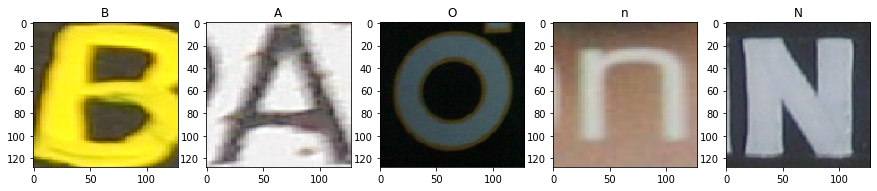

In [12]:
show_images(batchX[0:5], batchy[0:5])

### Строим модель. 

In [13]:
# конфигурирование слоев нейросети
model = Sequential()

model.add(InputLayer(input_shape = (128, 128, 3)))

model.add(Conv2D(filters=32, kernel_size=3,activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=3,activation='relu', padding='same'))
model.add(BatchNormalization())

# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(256,activation=Activation('relu')))
# model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(256,activation=Activation('relu')))
# model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(num_classes,activation=Activation('softmax')))

model.summary()

optimizer = Adam(learning_rate = 0.0001)

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        2

In [14]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
steps_per_epoch_testing = len(test_generator)
num_epochs = 100

In [15]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                              patience=7,
                              restore_best_weights=True)

In [16]:
#fit model
fit_history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch_training,
    epochs = num_epochs,
    validation_data = test_generator,
    validation_steps = steps_per_epoch_testing,
    callbacks = [early_stopping],
    verbose = 1
)

Epoch 1/100
382/382 [==============================] - 33s 53ms/step - loss: 4.4261 - accuracy: 0.0530 - val_loss: 4.1292 - val_accuracy: 0.0997
Epoch 2/100
382/382 [==============================] - 19s 49ms/step - loss: 3.6834 - accuracy: 0.1238 - val_loss: 3.1005 - val_accuracy: 0.2753
Epoch 3/100
382/382 [==============================] - 20s 52ms/step - loss: 3.2904 - accuracy: 0.2145 - val_loss: 2.7143 - val_accuracy: 0.3272
Epoch 4/100
382/382 [==============================] - 21s 54ms/step - loss: 3.0429 - accuracy: 0.2653 - val_loss: 2.4223 - val_accuracy: 0.4242
Epoch 5/100
382/382 [==============================] - 20s 53ms/step - loss: 2.6923 - accuracy: 0.3409 - val_loss: 2.0780 - val_accuracy: 0.5070
Epoch 6/100
382/382 [==============================] - 20s 52ms/step - loss: 2.5369 - accuracy: 0.3658 - val_loss: 1.9233 - val_accuracy: 0.5225
Epoch 7/100
382/382 [==============================] - 19s 50ms/step - loss: 2.3632 - accuracy: 0.3997 - val_loss: 1.6726 - val_ac

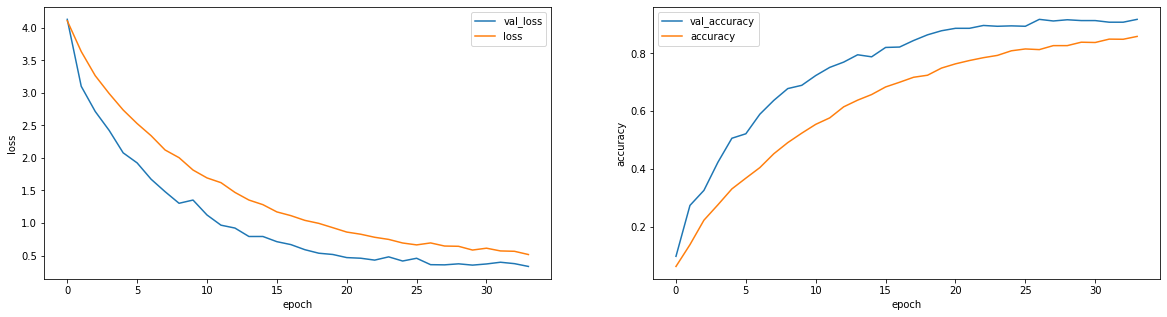

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

axes[0].plot(fit_history.history['val_loss'], label='val_loss')
axes[0].plot(fit_history.history['loss'], label='loss')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend()

axes[1].plot(fit_history.history['val_accuracy'], label='val_accuracy')
axes[1].plot(fit_history.history['accuracy'], label='accuracy')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].legend()

plt.show()

In [18]:
#evaluate the model
eval = model.evaluate(test_generator, verbose=0)
print('Model performance:')
print('loss for test dataset is : {}'.format(eval[0]))
print('accuracy for test dataset is : {}'.format(eval[1]))

Model performance:
loss for test dataset is : 0.3593207597732544
accuracy for test dataset is : 0.9171348214149475


In [19]:
#evaluate the model
eval = model.evaluate(validation_generator, verbose=0)
print('Model performance:')
print('loss for validation dataset is : {}'.format(eval[0]))
print('accuracy for validation dataset is : {}'.format(eval[1]))

Model performance:
loss for validation dataset is : 0.4359673857688904
accuracy for validation dataset is : 0.8893260955810547


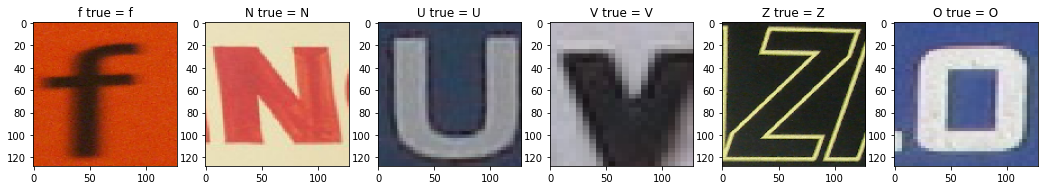

In [20]:
batchX, batchy = validation_generator.next()
pred = model.predict(batchX[0:6])
show_images(batchX[0:6], pred, batchy[0:6])

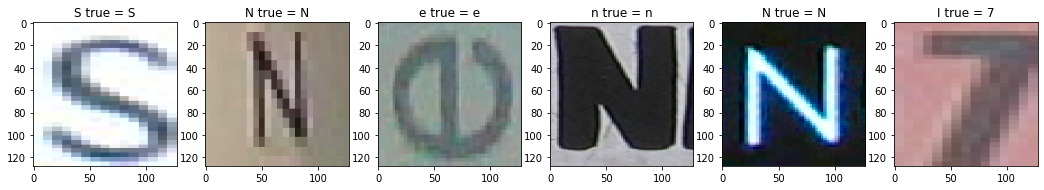

In [21]:
batchX, batchy = validation_generator.next()
pred = model.predict(batchX[0:6])
show_images(batchX[0:6], pred, batchy[0:6])

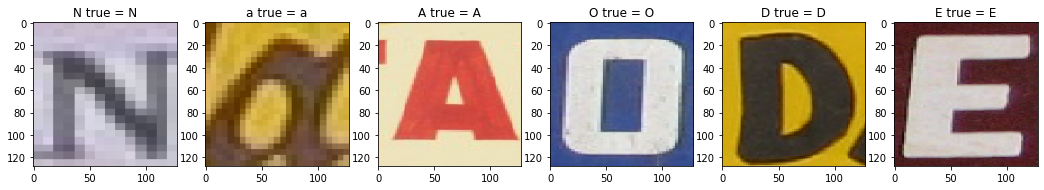

In [22]:
batchX, batchy = validation_generator.next()
pred = model.predict(batchX[0:6])
show_images(batchX[0:6], pred, batchy[0:6])

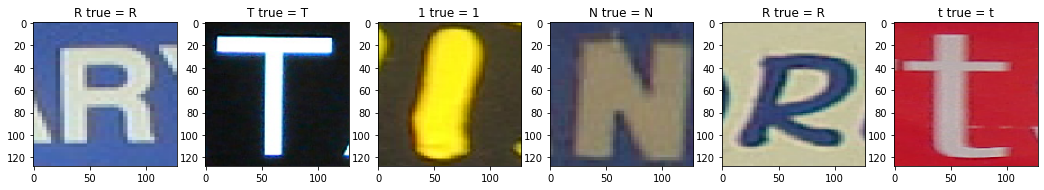

In [23]:
batchX, batchy = validation_generator.next()
pred = model.predict(batchX[0:6])
show_images(batchX[0:6], pred, batchy[0:6])

In [24]:
count = 0
y_true = []
y_preds = []
for _ in range(steps_per_epoch_validation):
    batchX, batchy  = validation_generator.next()
    preds = model.predict(batchX)
    count+=1
    for y, pred in zip(batchy, preds):
        y_true.append(class_name[np.argmax(y)])
        y_preds.append(class_name[np.argmax(pred)])

In [25]:
# Не сказать что получилось красиво. За-то достаточно наглядно. 
# По полученной таблице мы можем увидеть какие символы распознались хорошо, а какие не очень.
 
classification_report(y_true, y_preds,zero_division=0)

'              precision    recall  f1-score   support\n\n           0       0.77      0.77      0.77        26\n           1       0.88      0.79      0.83        19\n           2       1.00      0.95      0.97        20\n           3       0.82      0.75      0.78        12\n           4       1.00      0.80      0.89        15\n           5       0.94      0.89      0.91        18\n           6       0.89      0.94      0.91        17\n           7       0.77      0.91      0.83        11\n           8       0.00      0.00      0.00         8\n           9       0.67      0.29      0.40         7\n           A       0.97      0.97      0.97       141\n           B       0.95      0.95      0.95        37\n           C       0.96      0.89      0.92        53\n           D       0.96      0.96      0.96        48\n           E       0.98      0.96      0.97       113\n           F       0.81      1.00      0.90        22\n           G       0.95      0.97      0.96        39\n       

In [26]:
model.save_weights('Char74K.h5')

### Выводы: 

Но, в целом результат получился достаточно неплохой. В основном ошибки связаны с тем что не корректно определены 
регистры символов. 

Очень низкое к-во имеют модельпоказала для 'w','j','g','9', 'Q'. В остальном качество плучилось очень не плохое. 
Достаточно сильно помогли улучшить качество уменьшение занчения learning_rate в параметрах оптимизатора Adam и замена в полносвязных слоях BatchNormalization на Dropout. Однако, при этом снизилась скорость обучения.
